## Library

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import pycantonese
import jieba
import matplotlib.pyplot as plt
import emoji
import json
import csv
import pyLDAvis
import pyLDAvis.sklearn
import string
from zhon.hanzi import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

message, from, created_time, comments.limit(0).summary(1), reactions.limit(0).summary(1), reactions.type(LIKE).limit(0).summary(1).as(like), reactions.type(LOVE).limit(0).summary(1).as(love), reactions.type(HAHA).limit(0).summary(1).as(haha), reactions.type(WOW).limit(0).summary(1).as(wow), reactions.type(SAD).limit(0).summary(1).as(sad), reactions.type(ANGRY).limit(0).summary(1).as(angry)

In [24]:
# # Drop not-using columns
# not_using_col = ["id", "parent_id", "level", "object_id", "query_status", "query_time", "query_type",
#                 "paging.cursors.before", "paging.cursors.after", "paging.next", "reactions.summary.viewer_reaction",
#                 "sad.summary.viewer_reaction", "angry.data", "angry.summary.viewer_reaction", "updated_time", "error.message",
#                 "reactions.data", "id.1", "like.summary.total_count", "like.summary.viewer_reaction", "sad.data",
#                 "error.type", "error.code", "error.fbtrace_id", "from.name", "from.id", "like.data", "object_key", 
#                 "object_type", "reactions.summary.total_count", "sad.summary.total_count", "angry.summary.total_count"]
# df.drop(columns = not_using_col, inplace=True)

## 1. Clean df

In [103]:
#*********************************
Bank_name = 'HSBC'
#*********************************

Filename = f'FB_{Bank_name}_2022_v2.csv'
New_Filename = f'FBClean_{Bank_name}_v2.csv'

df = pd.read_csv(f'Collected_data/{Filename}', header=0)

In [104]:
# Drop non-data and NaN messages
drop_index = df[df.object_type != "data"].index
df.drop(axis = 0, index = drop_index, inplace = True)

drop_index = df[df.message.isna()].index
df.drop(axis = 0, index = drop_index, inplace = True)

# Categorization of reactions
df['pos_reaction'] = df['reactions.summary.total_count'] - df['sad.summary.total_count'] - df['angry.summary.total_count']
df['neg_reaction'] = df['sad.summary.total_count'] + df['angry.summary.total_count']

df = df.rename(columns = {'shares.count' : 'shares', 'comments.summary.total_count' : 'comments'})

In [105]:
df.columns

Index(['path', 'id', 'parent_id', 'level', 'object_id', 'object_type',
       'object_key', 'query_status', 'query_time', 'query_type', 'message',
       'created_time', 'updated_time', 'error.message', 'from.name', 'from.id',
       'comments.data', 'comments.summary.order', 'comments',
       'comments.summary.can_comment', 'reactions.data',
       'reactions.summary.total_count', 'reactions.summary.viewer_reaction',
       'like.data', 'like.summary.total_count', 'like.summary.viewer_reaction',
       'love.data', 'love.summary.total_count', 'love.summary.viewer_reaction',
       'haha.data', 'haha.summary.total_count', 'haha.summary.viewer_reaction',
       'wow.data', 'wow.summary.total_count', 'wow.summary.viewer_reaction',
       'sad.data', 'sad.summary.total_count', 'sad.summary.viewer_reaction',
       'angry.data', 'angry.summary.total_count',
       'angry.summary.viewer_reaction', 'id.1', 'summary.order',
       'summary.total_count', 'summary.can_comment', 'comment_count'

In [106]:
# Replace NaN with zero
df["shares"] = df["shares"].replace(np.nan,"0")
df["comments"] = df["comments"].replace(np.nan,"0")
df["pos_reaction"] = df["pos_reaction"].replace(np.nan,"0")
df["neg_reaction"] = df["neg_reaction"].replace(np.nan,"0")

# Change of column type to int
df["shares"] = df["shares"].apply(lambda x: int(x))
df["comments"] = df["comments"].apply(lambda x: int(x))
df["pos_reaction"] = df["pos_reaction"].apply(lambda x: int(x))
df["neg_reaction"] = df["neg_reaction"].apply(lambda x: int(x))

In [107]:
# Datetime
df["created_time"] = pd.to_datetime(df["created_time"])
df["date"] = df["created_time"].apply(lambda x: x.date())
df["date"] = pd.to_datetime(df["date"])

In [108]:
# Add bank name
df["bank"] = Bank_name

In [109]:
df = df.reindex(columns = ['bank', 'date','message', 'pos_reaction', 'neg_reaction', 'shares', 'comments'])

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

In [110]:
df.head(5)

,bank,date,message,pos_reaction,neg_reaction,shares,comments
0,HSBC,2022-09-30,【滙豐 Mobile Banking X 數碼科技 X 音樂🎵】 邊個話Banking 同...,29,0,0,4
1,HSBC,2022-09-30,【免佣免平台費 嬴在投資起跑線💨｜滙豐「調教少年股神」】 開Sem後又要chur grou...,15,1,0,2
2,HSBC,2022-09-29,【究竟乜嘢係元宇宙？web 3.0? DAO? VR?】 這些詞語和現實世界嘅我如何扯上關係...,13,1,0,1
3,HSBC,2022-09-29,【未響警號🚨就諗住遲啲先？無論身體健康定財政健康都唔好再拖喇！一齊為咗財政健康，戰勝拖延症！...,35,3,1,1
4,HSBC,2022-09-28,#睇片贏獎品【國泰航空／滙豐香港國際七人欖球賽有獎問答遊戲，贏取現場觀賽機會📣】 萬眾曯目嘅...,801,1,300,846


In [111]:
# Double-checking
df[df["neg_reaction"] < 0]

,bank,date,message,pos_reaction,neg_reaction,shares,comments


In [112]:
# Double-checking
df[df["pos_reaction"] < 0]

,bank,date,message,pos_reaction,neg_reaction,shares,comments


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   bank          210 non-null    object        
 1   date          210 non-null    datetime64[ns]
 2   message       210 non-null    object        
 3   pos_reaction  210 non-null    int64         
 4   neg_reaction  210 non-null    int64         
 5   shares        210 non-null    int64         
 6   comments      210 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 11.6+ KB


In [114]:
df.to_csv(f'Collected_data/{New_Filename}', encoding='utf-8-sig', index=False)

## 2. Concat df

In [115]:
df_1 = pd.read_csv('Collected_data/FBClean_ZA_v2.csv', header=0)
df_2 = pd.read_csv('Collected_data/FBClean_SC_v2.csv', header=0)
df_3 = pd.read_csv('Collected_data/FBClean_ICBC_v2.csv', header=0)
df_4 = pd.read_csv('Collected_data/FBClean_HSBC_v2.csv', header=0)
df_5 = pd.read_csv('Collected_data/FBClean_DBS_v2.csv', header=0)
df_6 = pd.read_csv('Collected_data/FBClean_BEA_v2.csv', header=0)

In [116]:
# Concat all df
frames = [df_1, df_2, df_3, df_4, df_5, df_6]  
df_master = pd.concat(frames, ignore_index=True)

In [117]:
display(df_master)

,bank,date,message,pos_reaction,neg_reaction,shares,comments
0,ZA,2022-09-26,"【突發：中巨獎有秘訣？有人用 $60 就贏到 $1,000,000?!】 呢個人就係新一位...",23,5,0,18
1,ZA,2022-09-23,【又食又拎基本啦！🍽 食勻港九再拎足 11% 回贈！😋】 TGIF! 常識題：放假食乜好...,20,2,4,3
2,ZA,2022-09-17,【SHAKE SHACK x ZA Bank 賞你免費漢堡】😋 過咗中秋，和煦嘅陽光下終於...,1102,0,618,1080
3,ZA,2022-09-16,【百萬勁抽限定！L 先生連環幸運事件】 23歲就有一百萬係咩概念？小編答你唔到，不過可以幫...,33,7,0,22
4,ZA,2022-09-10,【究竟邊個中咗一百萬 🤑⁉️】 數字有分先後！今期「百萬勁抽」獨贏號碼喺… 🥁 🥁 🥁 ...,51,8,3,36
...,...,...,...,...,...,...,...
718,BEA,2022-04-06,【第2季投資策略🎯】 上季資產市場一如舊年年底所料出現大幅波動。上季同大家分享咗3大投資主...,10,0,1,1
719,BEA,2022-04-04,【BEA Mall每月大抽獎🎁 春日簽賬贏取HK$500電子購物禮券】 踏入春季天氣濕笠笠...,292,3,6,3
720,BEA,2022-04-01,【電子錢包消費🌟享高達HK$80獎賞】 呢排抗疫時期，做咩都要打醒十二分精神！出街搭車同...,122,2,9,5
721,BEA,2022-04-01,【BEA Flash 開戶一觸即發】 劍擊講求靈活，反應要敏捷，動作要快先可以一擊即中。 ...,298,3,1,16


In [118]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   bank          723 non-null    object
 1   date          723 non-null    object
 2   message       723 non-null    object
 3   pos_reaction  723 non-null    int64 
 4   neg_reaction  723 non-null    int64 
 5   shares        723 non-null    int64 
 6   comments      723 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 39.7+ KB


In [120]:
# df_master.to_csv('Collected_data/FB_Banks_MasterData_v2.csv', encoding='utf-8-sig', index=False)

## 3. Word Cloud

In [264]:
#*********************************
bank_abbev = "BEA"
df = pd.read_csv(f'Collected_data/FB_Weibo_Bank/FB_{bank_abbev}_2022_v2.csv', encoding ="utf-8-sig")
#*********************************

# index
dt_now = str(dt.datetime.now())
dt_now = dt_now.replace("-","").replace(":","").replace(" ","")
dt_now = dt_now[0:14]

In [265]:
# Remove URL
df_noURL = df.message.apply(lambda x: re.sub(r'http\S+', '', x))

In [266]:
jieba.set_dictionary('dict.txt.big.txt')

In [267]:
# Word tokenization

# Combine all rows together for easier process
post_ALL = ''.join(df_noURL)

# Word tokens with length larger than 1
post_ALL_token = jieba.lcut(post_ALL, cut_all=True)
post_ALL_token_2 = [word for word in post_ALL_token if len(word.strip())>1]
word_list = " ".join(post_ALL_token_2)

Building prefix dict from C:\Users\user\Desktop\IS6912_IS_Project\dict.txt.big.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.ue2d2a202a1efb57383cecc3f28bf4cbd.cache
Loading model cost 1.210 seconds.
Prefix dict has been built successfully.


In [270]:
# Stopwords
# Cantonese
stop_words = pycantonese.stop_words()

# TC Stopwords
tc_stopwords = pd.read_csv("tc_stopwords.txt", header=None)
tc_stopwords = set(tc_stopwords[0])

# Eng Stopwords
eng_stopwords = stopwords.words('english')

# Additional stopwords
add_stopwd = set(["HKD", "ZA", "ZABank", "ZA Bank", "Bank", "BEA", "HSBC", "ICBC", "DBS", "SC", "HK", "Hong", "Kong", "com",
                  "香港", "眾安", "星展", "渣打", "東亞", "東亞銀行", "匯豐", "工銀", "有限公司", "銀行", "DBSHK"])

# Combine stopwords
tc_stopwords_union = tc_stopwords.union(stop_words, add_stopwd, eng_stopwords)

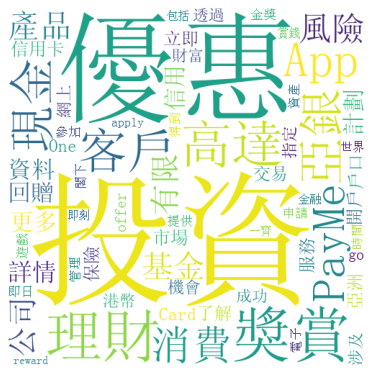

In [271]:
wordcloud = WordCloud(width = 500, height = 500,
                      font_path="simsun.ttf",
                      background_color ='white',
                      stopwords = tc_stopwords_union,
                      collocations=False,
                      min_font_size = 15).generate(word_list)

# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig(f'Bank_Wordcloud/{bank_abbev}_{dt_now}.png')
plt.show()

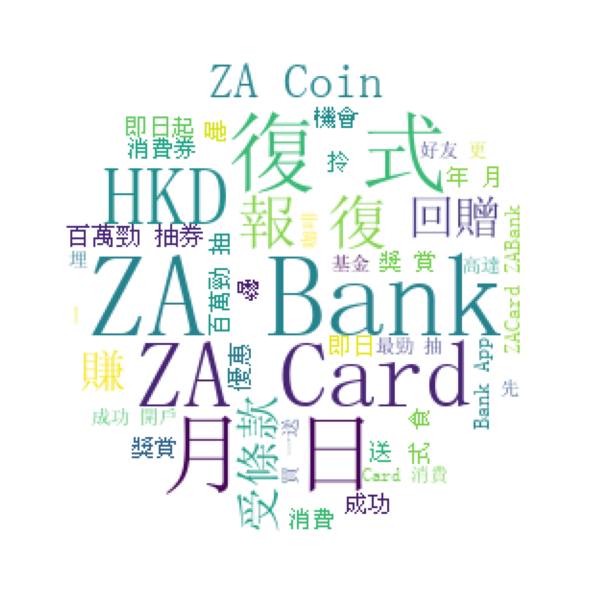

In [101]:
# makes the circle using numpy
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(width = 800, height = 800,
                      font_path="simsun.ttf",
                      background_color ='white',
                      stopwords = tc_stopwords_union,
                      mask = mask,
                      min_font_size = 10).generate(mytext_ALL_list)

# index
dt_now = str(dt.datetime.now())
dt_now = dt_now.replace("-","").replace(":","").replace(" ","")
dt_now = dt_now[0:14]

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig(f'Bank_Wordcloud/ZA_{dt_now}.png')
plt.show()

## 4. LDA (Topic Modelling)

### 4.1 Sample

In [5]:
df = pd.read_csv("Test_LDA_TopicModelling/datascience.csv", encoding='gb18030')

In [6]:
df.head(3)

,title,author,content
0,大数据产业迎政策暖风 最新大数据概念股一览,财经热点扒客,大数据产业发展受到国家重视，而大数据已经上升为国家战略，未来发展前景很广阔。大数据产业“十三...
1,Google发布机器学习平台Tensorflow游乐场～带你一起玩神经网络！,硅谷周边,点击上方“硅谷周边”关注我，收到最新的文章哦！昨天，Google发布了Tensorflow游...
2,李克强：中国大数据和云计算产业是开放的,苏州高新区金融办,国务院总理李克强当地时间20日上午在纽约下榻饭店同美国经济、金融、智库、媒体等各界人士座谈，...


<b>Word Tokenization using Jieba</b>

In [11]:
def chinese_word_cut(mytext):
    return " ".join(jieba.cut(mytext))

df["content_cutted"] = df.content.apply(chinese_word_cut)
df.content_cutted.head()

0    大 数据 产业 发展 受到 国家 重视 ， 而 大 数据 已经 上升 为 国家 战略 ， 未...
1    点击 上方 “ 硅谷 周边 ” 关注 我 ， 收到 最新 的 文章 哦 ！ 昨天 ， Goo...
2    国务院 总理 李克强 当地 时间 20 日 上午 在 纽约 下榻 饭店 同 美国 经济 、 ...
3    2016 年 ， 全峰 集团 持续 挖掘 大 数据 、 云 计算 、 “ 互联网 + ” 等...
4    贵州 理工学院 召开 大 数据分析 与 应用 专题 分享 会   借 “ 创响 中国 ” 贵...
Name: content_cutted, dtype: object

<b>Word Vectorization using TFIDF</b>

In [14]:
# Avoid extracting ALL keywords from the text
n_features = 1000
tf_vectorizer = CountVectorizer(strip_accents='unicode',
                                max_features=n_features,
                                stop_words='english',
                                # Ignore terms that have a document frequency > or < than the threshold
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(df.content_cutted)

<b>Apply LDA to train the model</b>

In [20]:
# Need to self define no. of topics
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, n_components=5, random_state=0)

In [21]:
# Print top words of each topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [23]:
# Set how many top words to get for each topic
n_top_words = 20

tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
学习 模型 使用 算法 方法 机器 可视化 神经网络 特征 处理 不同 计算 用户 数据库 系统 如果 分类 训练 一种 基于
Topic #1:
这个 就是 可能 没有 如果 他们 自己 很多 什么 不是 但是 或者 因为 时候 这样 现在 电子 一些 所以 孩子
Topic #2:
企业 平台 服务 管理 互联网 数据分析 公司 产品 用户 业务 行业 客户 金融 创新 实现 价值 系统 能力 工作 需求
Topic #3:
中国 2016 市场 增长 10 城市 用户 2015 关注 行业 其中 30 人口 检索 阅读 大众 投资 全国 美国 20
Topic #4:
人工智能 学习 领域 智能 机器人 机器 人类 公司 深度 研究 未来 识别 已经 系统 计算机 目前 医疗 语音 方面 服务



In [24]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

C:\Users\user\Documents\Anaconda\envs\yourenvname\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\user\Documents\Anaconda\envs\yourenvname\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.149635  0.021451       1        1  25.852071
2     -0.100942  0.102186       2        1  25.798362
1      0.127037 -0.112524       3        1  21.632325
4     -0.005510  0.118440       4        1  14.625269
3     -0.170219 -0.129553       5        1  12.091972, topic_info=     Term         Freq        Total Category  logprob  loglift
122  人工智能  2771.000000  2771.000000  Default  30.0000  30.0000
364    学习  4194.000000  4194.000000  Default  29.0000  29.0000
148    企业  3220.000000  3220.000000  Default  28.0000  28.0000
615    机器  2178.000000  2178.000000  Default  27.0000  27.0000
586    智能  1450.000000  1450.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
458    微信   266.676300   493.258458   Topic5  -5.2453   1.4976
845    行业   346.365488  1589.176433   Topic5  -4.9839   0.5892
560    数量   259.832297   467.563261   Topic5  -5.2713   1.5251
97     主要   273.202890  1246.241126   Topic5  -5.2211   0.5950
501    报告   257.056074   617.836739   Topic5  -5.2821   1.2357

[310 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.027158   00
0         5  0.969939   00
1         1  0.186738   10
1         2  0.044899   10
1         3  0.108165   10
...     ...       ...  ...
992       5  0.024959   领域
996       1  0.023137   驾驶
996       3  0.069412   驾驶
996       4  0.896569   驾驶
996       5  0.005784   驾驶

[1027 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

### 4.2 Facebook posts

In [108]:
bank_abbev = "ALL"
df = pd.read_csv(f'Collected_data/FB_Weibo_Bank/FBClean_{bank_abbev}_v2.csv', encoding='utf-8-sig', header=0)

In [109]:
df.head(3)

,bank,date,message,pos_reaction,neg_reaction,shares,comments
0,ZA,2022-09-26,"【突發：中巨獎有秘訣？有人用 $60 就贏到 $1,000,000?!】 呢個人就係新一位...",23,5,0,18
1,ZA,2022-09-23,【又食又拎基本啦！🍽 食勻港九再拎足 11% 回贈！😋】 TGIF! 常識題：放假食乜好...,20,2,4,3
2,ZA,2022-09-17,【SHAKE SHACK x ZA Bank 賞你免費漢堡】😋 過咗中秋，和煦嘅陽光下終於...,1102,0,618,1080


<b>Cantonese Stopwords</b>

In [110]:
# Stopwords
# Cantonese
stop_words = pycantonese.stop_words()

# TC Stopwords
tc_stopwords = pd.read_csv("tc_stopwords.txt", header=None)
tc_stopwords = set(tc_stopwords[0])

# Eng Stopwords
eng_stopwords = stopwords.words('english')

# Additional stopwords
add_stopwd = set(["HKD", "ZA", "ZABank", "ZA Bank", "Bank", "BEA", "HSBC", "ICBC", "DBS", "SC", "HK", "Hong", "Kong", "com", "bit", "亞銀", "閣下",
                  "香港", "眾安", "星展", "渣打", "東亞", "東亞銀行", "匯豐", "工銀", "有限公司", "銀行", "DBSHK", "html", "conditions", "terms", "ly",
                  'bank', 'bea', 'dbs', 'dbshk', 'hk', 'hkd', 'hong', 'hsbc', 'icbc', 'kong', 'sc', 'za', 'zabank', "condition", "term", '若果',
                  "grp"])

# Combine stopwords
tc_stopwords_union = tc_stopwords.union(stop_words, add_stopwd, eng_stopwords)

<b>Word Tokenization using Jieba</b>

In [111]:
jieba.set_dictionary('dict.txt.big.txt')

In [112]:
def chinese_word_cut(mytext):
    # Jieba - Word tokenization
    word_list = jieba.lcut(mytext, cut_all=True)
    word_list = [word for word in word_list if len(word.strip())>1]
    word_list = [i for i in word_list if not i.isdigit()]
    word_list = " ".join(word_list)
    
    # Remove punctuation marks
    word_list = word_list.translate(str.maketrans('', '', string.punctuation)) # English
    word_list = word_list.translate(str.maketrans('', '', punctuation)) # Chinese
    
    # Remove emojis
    word_list = emoji.get_emoji_regexp().sub(u'', word_list)
    return word_list

df["content_cutted"] = df.message.apply(chinese_word_cut)
df.content_cutted.head()

Building prefix dict from C:\Users\user\Desktop\IS6912_IS_Project\dict.txt.big.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.ue2d2a202a1efb57383cecc3f28bf4cbd.cache
Loading model cost 1.254 seconds.
Prefix dict has been built successfully.


0    突發 有人 贏到  個人 一位 百萬 幸運 幸運兒 雷先生 先生 第二 第二位 二位 贏得 ...
1    基本  港九 回贈  TGIF 常識 放假 即刻 好多 多間 餐廳 無論 只要 ZA Ban...
2    SHAKE SHACK ZA Bank 免費 漢堡  中秋 和煦 陽光 終於 帶有 陣陣 微...
3    百萬 限定 先生 連環 幸運 事件 一百 一百萬 百萬 概念 不過 可以 百萬 得獎 得獎者...
4    究竟 邊個 一百 一百萬 百萬  數字 先後 今期 百萬 號碼 53F8Z 恭喜 今期 百萬...
Name: content_cutted, dtype: object

<b>Word Vectorization using TFIDF</b>

In [113]:
# Avoid extracting ALL keywords from the text
n_features = 1000
tf_vectorizer = CountVectorizer(strip_accents='unicode',
                                max_features=n_features,
                                stop_words=tc_stopwords_union,
                                # Ignore terms that have a document frequency > or < than the threshold
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(df.content_cutted)

<b>Apply LDA to train the model</b>

In [114]:
# Need to self define no. of topics
n_topics = 7
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, n_components=7, random_state=0)

In [115]:
# Print top words of each topics
def print_top_words(model, feature_names, n_top_words):
    print(bank_abbev, "Bank Topics:\n")
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [116]:
# Set how many top words to get for each topic
n_top_words = 20

tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

ALL Bank Topics:

Topic #0:
世界 持續 更多 百萬 發展 綠色 環保 了解 基金 工作 藝術 一齊 報復 go 支持 透過 生活 world 食物 livemorebankless
Topic #1:
投資 資料 產品 公司 視訊 意見 有限 資產 作出 未經 發佈 文件 市場 銷售 決定 代表 建議 風險 出任 保證
Topic #2:
獎賞 優惠 現金 高達 信用 回贈 信用卡 app card 消費 詳情 指定 金獎 賞錢 即日 電子 額外 得到 起至 即日起
Topic #3:
遊戲 機會 抽獎 得獎 參加 facebook 優先 日期 有獎 國泰 有機 留言 活動 理財 like 朋友 超越 禮券 得獎者 win
Topic #4:
投資 理財 基金 風險 客戶 亞洲 市場 涉及 財富 交易 管理 優惠 戶口 認購 服務 分析 網上 高達 提供 債券
Topic #5:
保險 理財 one 計劃 investment app 投資 保障 公司 有限 wealth banking 健康 life 產品 time 保單 well apply 客戶
Topic #6:
payme 消費 優惠 港幣 voucher svfb002 get paymehk 階段 consumption 登記 八達 八達通 優惠券 paymeow 第二 app 第二階段 二階 折扣



In [117]:
# index
dt_now = str(dt.datetime.now())
dt_now = dt_now.replace("-","").replace(":","").replace(" ","")
dt_now = dt_now[0:14]

pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.save_html(p, f'Test_LDA_TopicModelling/LDA_{bank_abbev}_{dt_now}.html')

C:\Users\user\Documents\Anaconda\envs\yourenvname\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\user\Documents\Anaconda\envs\yourenvname\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## End